<a href="https://www.kaggle.com/code/ayushgpt8/retail-data-summary?scriptVersionId=158725557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Summarizing Retail Data - Grouping and aggregating data

For this notebook, we will be exploring the techniques for grouping and aggregating data. We will use data from https://archive.ics.uci.edu/ml/datasets/online+retail

Table of contents:
- Speeding up data loading with Feather
- Grouping data using pandas library
- Plotting Aggregations
- Limiting Groups
- Aggregating data using built-in functions
- Manipulating Plot


## Load Data

The data can be downloaded from the above url.
In this case, someone has already uploaded this data on kaggle so we'll just use that instead of manually downloading and unzipping it.

In [1]:
import pandas as pd

In [2]:
sales = pd.read_excel("/kaggle/input/retail-sales-dataset-sample-transactions/Online Retail Data Set.xlsx", dtype_backend='pyarrow')

In [3]:
sales

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


Since this dataset is on the heavier side than usual, we can use feather to speed this up.

In [4]:
(sales
    .astype(
        {"InvoiceNo": "str", "StockCode": "str", "Description": "str"}
    ).to_feather("/kaggle/working/retail_feather.fth")
)

In [5]:
# loading the feather takes significantly less time
sales_f = pd.read_feather("/kaggle/working/retail_feather.fth", dtype_backend='pyarrow')

In [6]:
%%timeit
sales_f = pd.read_feather("/kaggle/working/retail_feather.fth", dtype_backend='pyarrow')

23.4 ms ± 852 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# commenting this out since this takes a long time to run
# %%timeit
# sales = pd.read_excel("/kaggle/input/retail-sales-dataset-sample-transactions/Online Retail Data Set.xlsx", dtype_backend='pyarrow')

## EDA
Lets explore the data a bit

In [8]:
import numpy as np

sales_f.describe(include=np.number)

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Here, we have to include the parameter `include=np.number` in order to explicitly tell it to only use numerical columns. Otherwise it throws an error `ArrowNotImplementedError: Unsupported cast from double to timestamp using function cast_timestamp`.

We also see that the minimum `UnitPrice` is `-11062.060`, which is very weird. How can the unit price be negative. Lets look at that. Similarly, we have negative `Quantity` value of `-80995.000`. Let's explore this as well.

<Axes: >

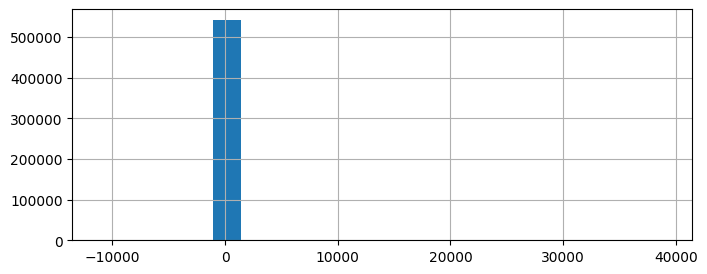

In [9]:
sales_f.UnitPrice.hist(figsize=(8, 3), bins=20)

In [10]:
sales_f.query("UnitPrice < 0")

/tmp/ipykernel_18/2961295632.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sales_f.query("UnitPrice < 0")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom


Now that's little clearer. If you look at the description, we see that the negative unit price was an adjustment of bad debt. Let's look at `Quantity` next.

In [11]:
sales_f.query("Quantity < 0")

/tmp/ipykernel_18/3643450623.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sales_f.query("Quantity < 0")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


We see a lot of legitimate looking orders with negative quantity with higher quantity values form `CustomerID` of `17548`.

In [12]:
sales_f.query("CustomerID == 17548")

/tmp/ipykernel_18/950633959.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  sales_f.query("CustomerID == 17548")


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548,United Kingdom


It looks like there may have been an error while entering the quantity. But looking closely, we see only the `InvoiceNo` that does not start with `C` have positive quantity orders. These maybe the orders that were returned. If you look at the rows 165025 and 177225 or 165028 and 177223, they have the exact same `Description`, `StockCode`, `UnitPrice`, just with one negative and one postive `Quantity`. But since not all of the orders here follow this pattern, we may have to investigate this further later on.

Let's look at some non-numeric columns for now

In [13]:
sales_f.select_dtypes("string")

,InvoiceNo,StockCode,Description,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,France


In [14]:
sales_f.Country.value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


It looks like vast majority of the orders are from United Kingdom

In [15]:
sales_f.StockCode.value_counts()

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
23609        1
85179a       1
23617        1
90214U       1
47591b       1
Name: count, Length: 4070, dtype: int64[pyarrow]

## Sales by Year

Let's look at the sales data by year.

In [16]:
# we can use .assign() here to add new columns
(sales_f
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011


In [17]:
(sales_f
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
    .groupby('year')
    .sum(numeric_only=True) # here numeric_only is necessary, otehrwise pandas will throw an error
)

,Quantity,UnitPrice,CustomerID,total
year,,,,
2010,342228,260520.850,416697748,748957.020
2011,4834222,2238283.124,5802778119,8998790.914


<Axes: title={'center': 'Sales by Year'}, xlabel='year', ylabel='total - quantity * unitprice'>

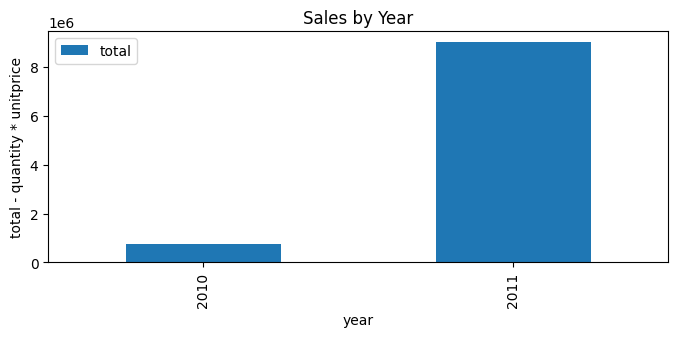

In [18]:
# lets plot it
(sales_f
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
    .groupby('year')
    .sum(numeric_only=True) # here numeric_only is necessary, otehrwise pandas will throw an error
    .total.plot.bar(title='Sales by Year', figsize=(8,3), ylabel='total - quantity * unitprice', legend=True)
)

## Sales by Country

How about sales by country. We saw majority of orders coming from UK. Let's look at them closely.

<Axes: title={'center': 'Sales by Country'}, xlabel='Country', ylabel='total - quantity * unitprice'>

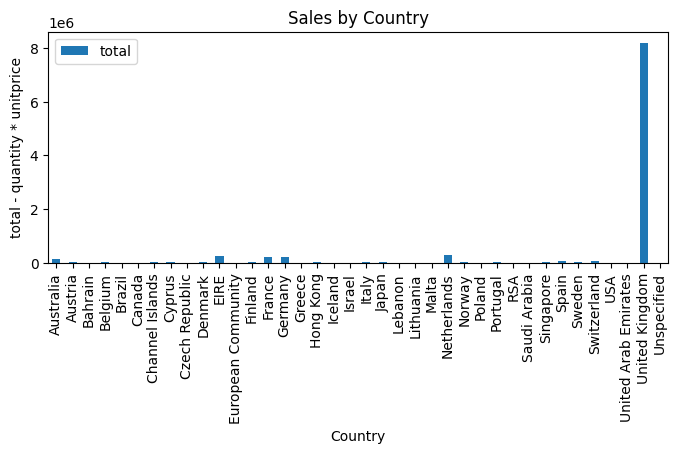

In [19]:
(sales_f
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
    .groupby("Country")
    .sum(numeric_only=True)
    .total.plot.bar(title="Sales by Country", figsize=(8, 3), ylabel='total - quantity * unitprice', legend=True)
)

UK here really skews the graph. There are many orders from other countries that are just not visible here. Let's remove UK for now and see how other countries do.

<Axes: title={'center': 'Sales by Country'}, xlabel='Country', ylabel='total - quantity * unitprice'>

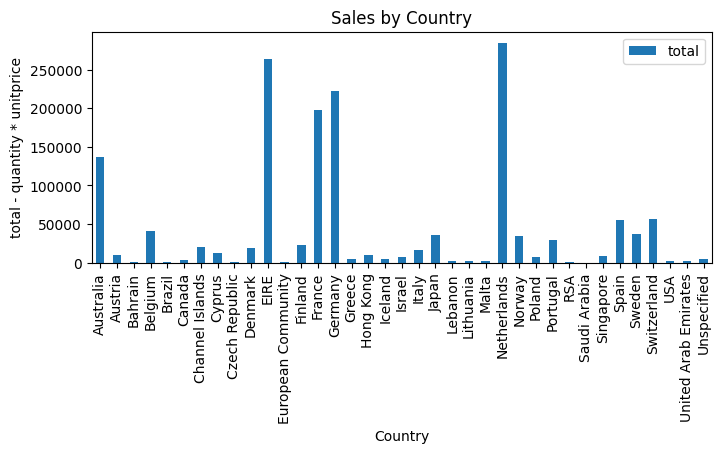

In [20]:
(sales_f
    .query('Country != "United Kingdom"')
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
    .groupby("Country")
    .sum(numeric_only=True)
    .total.plot.bar(title="Sales by Country", figsize=(8, 3), ylabel='total - quantity * unitprice', legend=True)
)

Let's sort it from most orders to least orders by countries and change the orientation for better readability.

<Axes: title={'center': 'Sales by Country'}, xlabel='total - quantity * unitprice', ylabel='Country'>

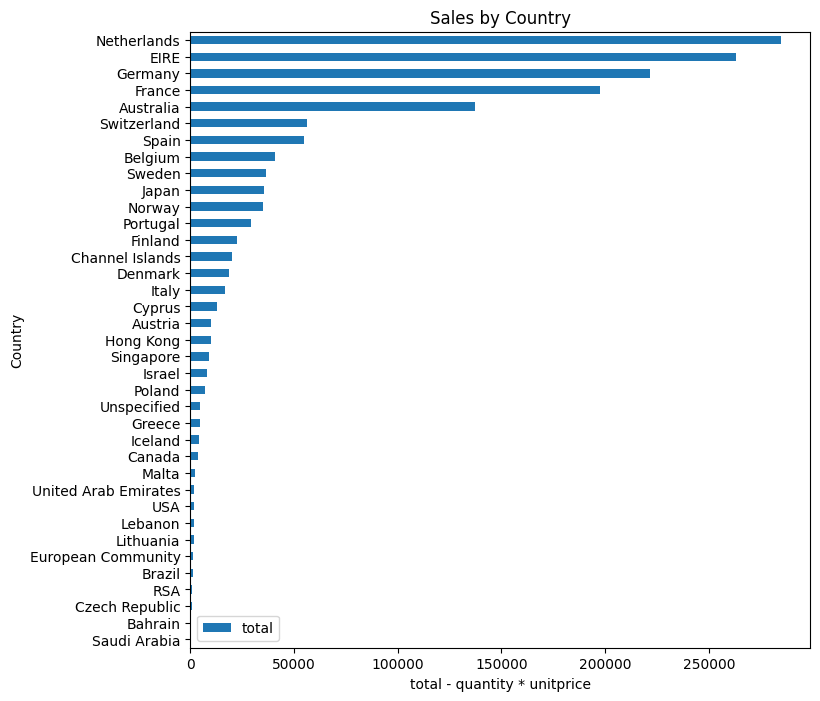

In [21]:
(sales_f
    .query('Country != "United Kingdom"')
    .assign(total=sales_f.Quantity * sales_f.UnitPrice, year=sales_f.InvoiceDate.dt.year)
    .groupby("Country")
    .sum(numeric_only=True)
    .total.sort_values()
    .plot.barh(title="Sales by Country", figsize=(8, 8), xlabel='total - quantity * unitprice', legend=True)
)

There are a lot of countries here. Many of which dont have a lot of orders. We can reduce the cognitive load by taking the top countries with orders and grouping the rest in 'Other' category.

In [22]:
# lets take top 10 countries
n = 10
top = sales_f.Country.value_counts()

topn = top.index[:n]

(sales_f
    .assign(Country = sales_f.Country.where(sales_f.Country.isin(topn), 'Other'))
    .Country.value_counts()
)

Country
United Kingdom    495478
Germany             9495
France              8557
Other               8430
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64[pyarrow]

In [23]:
# we'll turn the above login into a function
def limit_n(df, col, n=20, other='Other'):
    top = df[col].value_counts()
    
    topn = top.index[:n]
    return df[col].where(df[col].isin(topn), other)

limit_n(sales_f, "Country").value_counts()

Country
United Kingdom     495478
Germany              9495
France               8557
EIRE                 8196
Spain                2533
Other                2410
Netherlands          2371
Belgium              2069
Switzerland          2002
Portugal             1519
Australia            1259
Norway               1086
Italy                 803
Channel Islands       758
Finland               695
Cyprus                622
Sweden                462
Unspecified           446
Austria               401
Denmark               389
Japan                 358
Name: count, dtype: int64[pyarrow]

<Axes: title={'center': 'Sales by Country'}, xlabel='total - quantity * unitprice', ylabel='Country'>

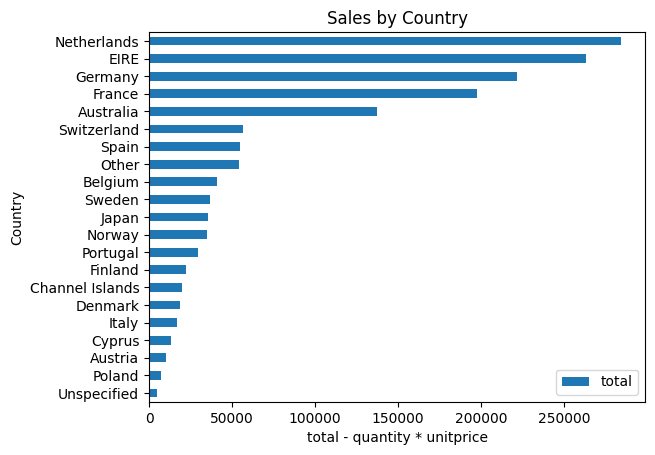

In [24]:
# using the function to create/update a column
(sales_f
    .query('Country != "United Kingdom"')
    .assign(
        Country=lambda df: limit_n(df, "Country"),
        total=lambda df: df.Quantity * df.UnitPrice,
        year=lambda df: df.InvoiceDate.dt.year,
    )
    .groupby("Country")
    .sum(numeric_only=True)
    .total.sort_values()
    .plot.barh(title="Sales by Country", xlabel='total - quantity * unitprice', legend=True)
)

## Sales by Month

Let's see some sales by month

In [25]:
(sales_f
    .astype({'InvoiceDate':'datetime64[ns]'}) # need to convert to avoid TypeError
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby(pd.Grouper(key='InvoiceDate', freq='M'))
    .sum(numeric_only=True)
)

,Quantity,UnitPrice,CustomerID,total
InvoiceDate,,,,
2010-12-31,342228,260520.850,416697748,748957.020
2011-01-31,308966,172752.800,331919771,560000.260
2011-02-28,277989,127448.770,311780860,498062.650
2011-03-31,351872,171486.510,422329758,683267.080
2011-04-30,289098,129164.961,354119428,493207.121
2011-05-31,380391,190685.460,440008786,723333.510
2011-06-30,341623,200717.340,426470991,691123.120
2011-07-31,391116,171906.791,420922578,681300.111
2011-08-31,406199,150385.680,421947808,682680.510


<Axes: xlabel='InvoiceDate', ylabel='total - quantity * unitprice'>

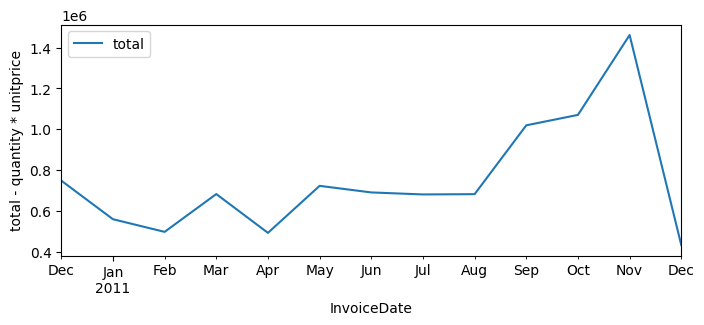

In [26]:
# sales on monthly basis
(sales_f
    .astype({'InvoiceDate':'datetime64[ns]'}) # need to convert to avoid TypeError
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby(pd.Grouper(key='InvoiceDate', freq='M'))
    .sum(numeric_only=True)
    .total
    .plot(figsize=(8,3), legend=True, ylabel='total - quantity * unitprice')
)

<Axes: xlabel='InvoiceDate', ylabel='total - quantity * unitprice'>

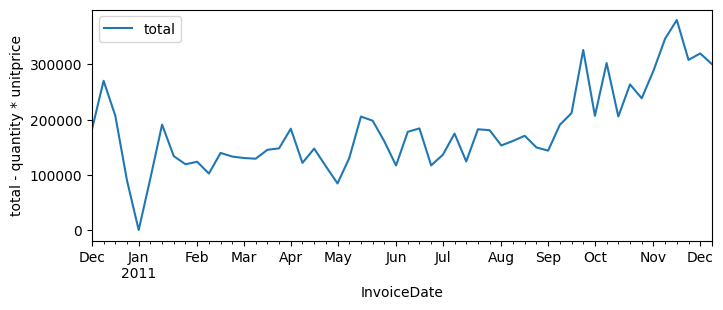

In [27]:
# sales on weekly basis
(sales_f
    .astype({'InvoiceDate':'datetime64[ns]'}) # need to convert to avoid TypeError
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby(pd.Grouper(key='InvoiceDate', freq='w'))
    .sum(numeric_only=True)
    .total
    .plot(figsize=(8,3), legend=True, ylabel='total - quantity * unitprice')
)

<Axes: xlabel='InvoiceDate', ylabel='total - quantity * unitprice'>

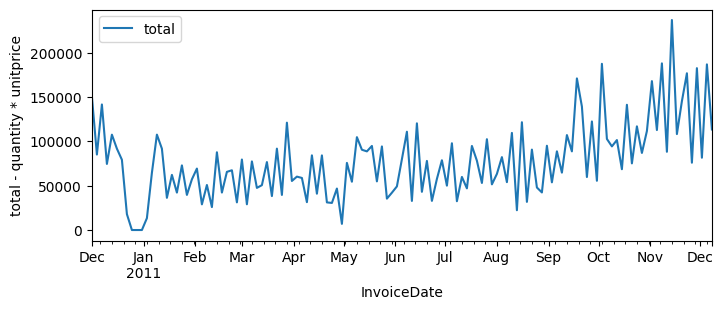

In [28]:
# sales on 3d basis
(sales_f
    .astype({'InvoiceDate':'datetime64[ns]'}) # need to convert to avoid TypeError
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby(pd.Grouper(key='InvoiceDate', freq='3d'))
    .sum(numeric_only=True)
    .total
    .plot(figsize=(8,3), legend=True, ylabel='total - quantity * unitprice')
)

## Sales by Month for Top N Countries

What about sales by month for top countries? Lets look at those

In [29]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total
)

InvoiceDate  Country       
2010-12-01   Australia           358.25
             EIRE                555.38
             France              855.86
             Germany             139.18
             Netherlands         192.60
                                 ...   
2011-12-09   Belgium             208.64
             France              249.45
             Germany            1689.72
             Norway             2638.69
             United Kingdom    27345.03
Name: total, Length: 1716, dtype: double[pyarrow]

<Axes: xlabel='InvoiceDate,Country'>

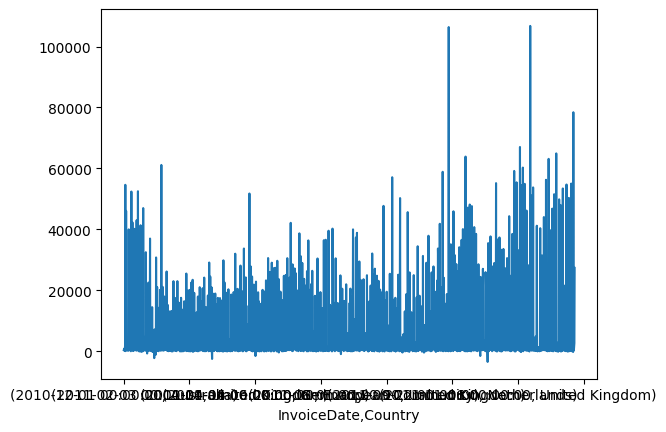

In [30]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total.plot()
)

Thats not hepful at all. Lets openup this groupby object to see what is happening inside.

In [31]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total.unstack()
)

Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01,358.25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,54615.15,<NA>
2010-12-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,46053.93,<NA>
2010-12-03,<NA>,<NA>,<NA>,346.1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,620.0,<NA>,303.4,<NA>,<NA>,39985.44,<NA>
2010-12-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25462.20,<NA>
2010-12-06,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,52402.84,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,198.4,<NA>,<NA>,168.9,...,<NA>,<NA>,<NA>,<NA>,0.0,<NA>,615.28,<NA>,54715.25,<NA>
2011-12-06,<NA>,<NA>,<NA>,898.77,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,172.06,<NA>,<NA>,<NA>,<NA>,50307.31,<NA>
2011-12-07,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,99.37,<NA>,<NA>,<NA>,<NA>,55028.58,<NA>


In [32]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total
    .unstack().fillna(0) # we will replace all nans with 0
)

Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01,358.25,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,54615.15,0.0
2010-12-02,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,46053.93,0.0
2010-12-03,0.00,0.0,0.0,346.10,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,620.00,0.0,303.4,0.00,0.0,39985.44,0.0
2010-12-05,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,25462.20,0.0
2010-12-06,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,52402.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.00,0.0,0.0,0.00,0.0,0.0,198.40,0.0,0.0,168.9,...,0.0,0.0,0.0,0.00,0.0,0.0,615.28,0.0,54715.25,0.0
2011-12-06,0.00,0.0,0.0,898.77,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,172.06,0.0,0.0,0.00,0.0,50307.31,0.0
2011-12-07,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,99.37,0.0,0.0,0.00,0.0,55028.58,0.0


<Axes: xlabel='InvoiceDate'>

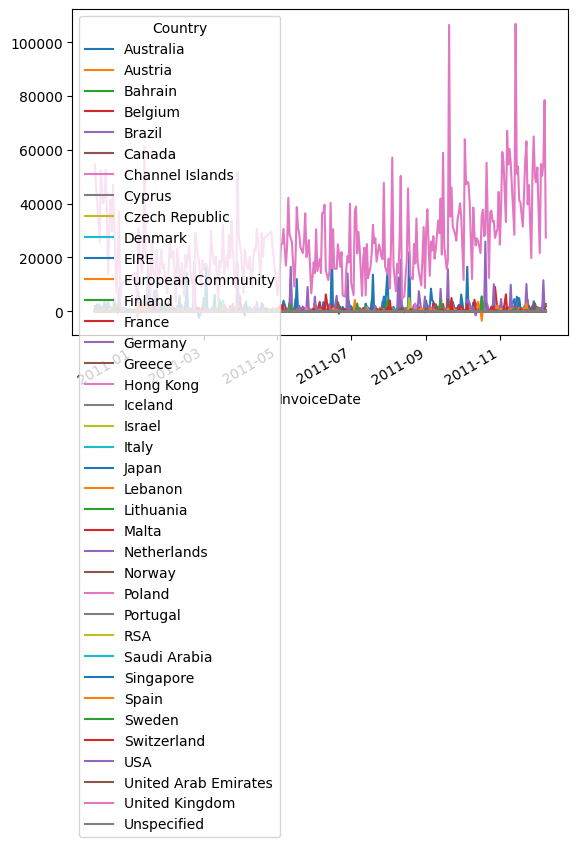

In [33]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .assign(total=lambda df: df.Quantity * df.UnitPrice)
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total
    .unstack().fillna(0)
    .plot()
)

Lets remove United Kingdom since we already know that it has highest sales by a lot. We will also limit the list of countries listed in the legend using the `limit_n` function we defined earlier.

<Axes: xlabel='InvoiceDate'>

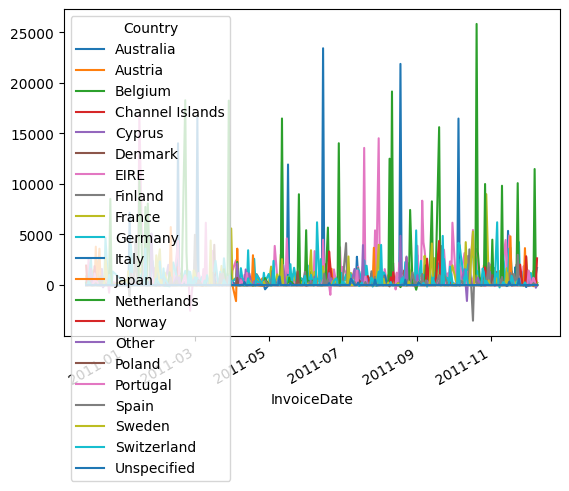

In [34]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .query('Country != "United Kingdom"')
    .assign(
        Country=lambda df: limit_n(df, "Country"),
        total=lambda df: df.Quantity * df.UnitPrice,
    )
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total.unstack()
    .fillna(0)
    .plot()
)

We'll now make the legend box in two columns for better readability.

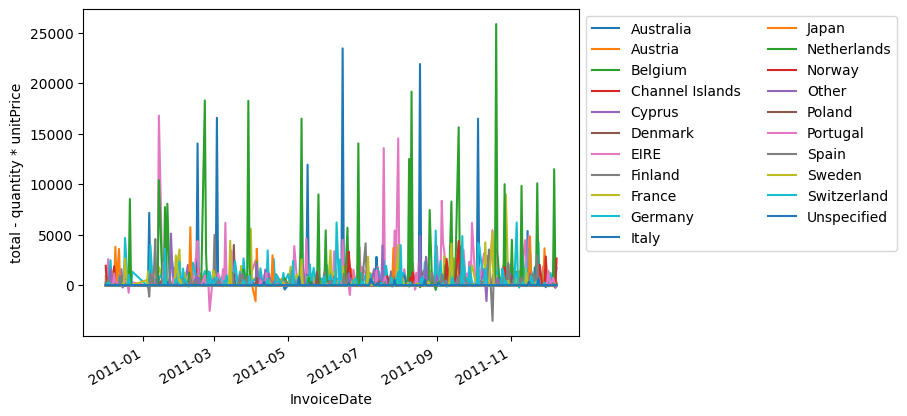

In [35]:
(sales_f
    .astype({"InvoiceDate": "datetime64[ns]"})
    .query('Country != "United Kingdom"')
    .assign(
        Country=lambda df: limit_n(df, "Country"),
        total=lambda df: df.Quantity * df.UnitPrice,
    )
    .groupby([pd.Grouper(key="InvoiceDate", freq="d"), "Country"])
    .sum(numeric_only=True)
    .total.unstack()
    .fillna(0)
    .plot(ylabel='total - quantity * unitPrice')
    .legend(bbox_to_anchor=(1, 1), ncols=2)
)

This looks perfect and we can leave it at that. But lets take it a step further.

What if we wanted to highlight a specific country. It is still hard to see sales for a country with lower sales. Let's highlight a particular country with red and the rest colored by a single color. We can change that based on which country we want to see. This can come in handy when viewing graphs like this on a dashboard.

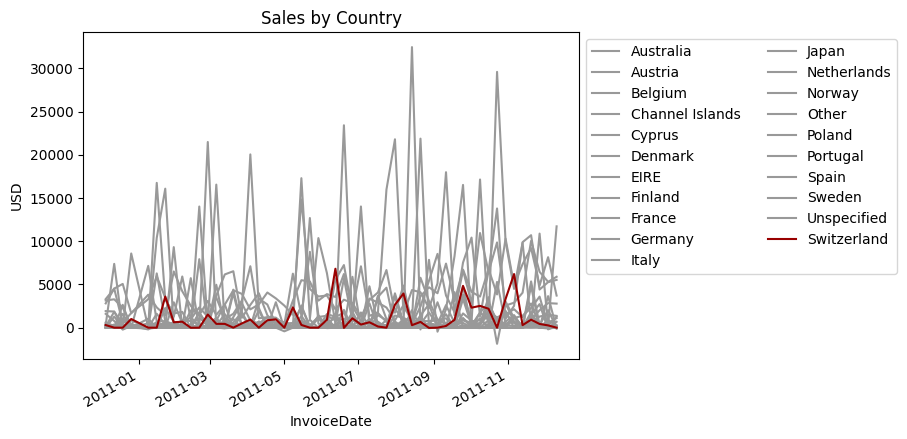

In [36]:
colors = []


def set_colors(df, country, normal="#999999", hl="#990000"):
    cols = []
    for col in df.columns:
        if col != country:
            colors.append(normal)
            cols.append(col)
    colors.append(hl)
    cols.append(country)
    return df.loc[:, cols]


def plot(df):
    ax = df.plot(color=colors, title="Sales by Country")
    ax.legend(bbox_to_anchor=(1, 1), ncols=2)
    ax.set_ylabel("USD")
    return df

country_name = 'Switzerland'    # we can change country name here and that country line will be highlighted in the graph

final = (sales_f
            .astype({"InvoiceDate": "datetime64[ns]"})
            .query('Country != "United Kingdom"')
            .assign(
                Country=lambda df: limit_n(df, "Country"),
                total=lambda df: df.Quantity * df.UnitPrice,
            )
            .groupby([pd.Grouper(key="InvoiceDate", freq="w"), "Country"])
            .sum(numeric_only=True)
            .total.unstack()
            .fillna(0)
            .pipe(set_colors, country=country_name)
            .pipe(plot)
        )

Now we can just put the country name in that variable and see the country highlighted in the graph.